# Two stage COVID-ResNet 

In this notebook, we work on a two stage supervised classifier using the `Fast.ai` library. 

During the first stage, the network is trained to classify between `Pneumonia` and `normal` using the original `COVIDx` dataset. Once the classifier reaches a decent accuracy classifying between the two classes, then we fine-tuned only between `covid` and `other`, where `other` contains both samples from `pneumonia` and `normal`. 

In [ ]:
import pandas as pd
import numpy as np
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
from fastai.callbacks import SaveModelCallback
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
#from model_utils import custom_path_load, custom_path_save

# Data

We use two different datasets:

* https://github.com/ieee8023/covid-chestxray-dataset, containing 99 COVID, 17 bacterial and 11 viral chest x-ray images. 

*  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge containing 1345 viral and 2530 bacterial images.  


Images have to be preprocessed a-priori using this attached [noteboook](./data_discovery.ipynb).

Processed images are stored in `data/COVIDx`.  We import the training and testing `Dataframes` to select the correspondent labels. 

In [82]:
train_path = 'data/COVIDx/train'
df_train = pd.read_pickle('covidX_train.pkl')
df_test = pd.read_pickle('covidX_test.pkl')

# 1st Stage training
----------------


Using a `resnet50` model. Trying to differentiate between `pnenumonia` and `normal`. Select these classes from the dataset.


## Dataset creation

In [ ]:
rsna_samples = np.invert(df_train['label'] == 'covid')
df_train_rsna = df_train[rsna_samples]
df_train_rsna.describe()

## Data augmentation

Data augmentation helps in creating newer examples by applying different transformation randomly to the available training images. In this work, the transformation that we used included vertical flips of the training images, random rotation of the images (maximum rotation angle was 15 degree), and lighting conditions. Data augmentation increases the size of input training data along with the model regularization and hence improving generalization of the training model. Only the training data was augmented, and the test time augmentation was not explored.

In [ ]:
transforms = get_transforms(do_flip=True, 
                            flip_vert=False,
                            max_rotate=15)

## Model utils

In [ ]:
model_name = 'resnet_covidx_pneumonia'

model_path = os.path.join('models', model_name)

# create the models folder
if os.path.exists('models') is False:
    os.mkdir('models')

# create the current model folder
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
   

def custom_path_save(self, 
                     name:PathOrStr, 
                     path='models', 
                     return_path:bool=False, 
                     with_opt:bool=True):
    '''
    Save model and optimizer state (if `with_opt`) 
    with `name` to `self.model_dir`."
    '''
    if path == '': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    if not with_opt: 
        state = get_model(self.model).state_dict()
    else: 
        state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
    torch.save(state, path)
    
    if return_path: 
        return path

def custom_path_load(self, 
                     name:PathOrStr, 
                     path='models', 
                     device:torch.device=None, 
                     strict:bool=True, 
                     with_opt:bool=None,
                     purge=False):
    """
    Load model and optimizer state (if `with_opt`) `name` 
    from `self.model_dir` using `device`."

    """
    if device is None: 
        device = self.data.device
    if path=='': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    
    state = torch.load(path, map_location=device) 
    if set(state.keys()) == {'model', 'opt'}:
        get_model(self.model).load_state_dict(state['model'], strict=strict)
        if ifnone(with_opt,True):
            if not hasattr(self, 'opt'): 
                opt = self.create_opt(defaults.lr, self.wd)
            try:    
                self.opt.load_state_dict(state['opt'])
            except: 
                pass
    else:
        if with_opt: 
            warn("Saved filed doesn't contain an optimizer state.")
        get_model(self.model).load_state_dict(state, strict=strict)
    return self

In [ ]:
model_name = 'resnet_covidx_pneumonia'

model_path = os.path.join('models', model_name)

# create the models folder
if os.path.exists('models') is False:
    os.mkdir('models')

# create the current model folder
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
   

def custom_path_save(self, 
                     name:PathOrStr, 
                     path='models', 
                     return_path:bool=False, 
                     with_opt:bool=True):
    '''
    Save model and optimizer state (if `with_opt`) 
    with `name` to `self.model_dir`."
    '''
    if path == '': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    if not with_opt: 
        state = get_model(self.model).state_dict()
    else: 
        state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
    torch.save(state, path)
    
    if return_path: 
        return path

def custom_path_load(self, 
                     name:PathOrStr, 
                     path='models', 
                     device:torch.device=None, 
                     strict:bool=True, 
                     with_opt:bool=None,
                     purge=False):
    """
    Load model and optimizer state (if `with_opt`) `name` 
    from `self.model_dir` using `device`."

    """
    if device is None: 
        device = self.data.device
    if path=='': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    
    state = torch.load(path, map_location=device) 
    if set(state.keys()) == {'model', 'opt'}:
        get_model(self.model).load_state_dict(state['model'], strict=strict)
        if ifnone(with_opt,True):
            if not hasattr(self, 'opt'): 
                opt = self.create_opt(defaults.lr, self.wd)
            try:    
                self.opt.load_state_dict(state['opt'])
            except: 
                pass
    else:
        if with_opt: 
            warn("Saved filed doesn't contain an optimizer state.")
        get_model(self.model).load_state_dict(state, strict=strict)
    return self

## Model creation

In [ ]:
data = ImageDataBunch.from_df(path='.', 
                              df=df_train_rsna,
                              valid_pct=0.25,
                              test=None,
                              ds_tfms=transforms, 
                              bs=32, 
                              size=256, 
                              num_workers=8).normalize(imagenet_stats)

#show size of our datasets
print("TRAIN:", len(data.train_ds),
      "VALIDATION:", len(data.valid_ds))

precision = Precision()
AUC = AUROC()
learn = cnn_learner(data, models.resnet50, metrics=(accuracy, precision, error_rate, AUC)) 

# data.show_batch(rows=3, figsize=(10,10))

### 1st round

In [ ]:
learn.freeze()
learn.fit_one_cycle(3, max_lr=1e-3)

In [ ]:
# find the best learning rate with discriminataive learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-06,1e-04))
learn.save(os.path.join(model_name, model_name + '_stage1'))

### 2nd round

In [ ]:
learn.load(os.path.join(model_name, model_name + '_stage1'))
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(30, max_lr=slice(1e-06,1e-04))
learn.save(os.path.join(model_name, model_name + '_stage2'))

### 3rd round

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


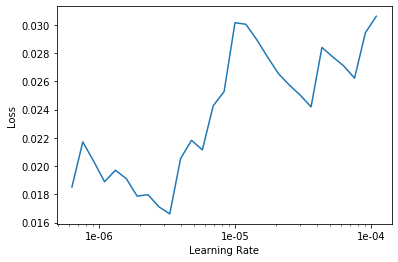

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(10, max_lr=slice(1e-06,1e-05))
learn.save(os.path.join(model_name, model_name + '_stage3'))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.023397,0.171888,0.959016,0.958853,0.040984,0.989485,01:30
1,0.018327,0.183378,0.958534,0.962238,0.041466,0.989019,01:30
2,0.019146,0.185115,0.958775,0.966604,0.041225,0.988721,01:30
3,0.022104,0.179938,0.957329,0.960428,0.042671,0.988819,01:30
4,0.026562,0.178499,0.956847,0.954462,0.043153,0.989341,01:31
5,0.018024,0.182954,0.959016,0.955903,0.040984,0.989130,01:30
6,0.018584,0.190966,0.958293,0.959647,0.041707,0.988471,01:31
7,0.023372,0.189547,0.957329,0.959572,0.042671,0.988853,01:30
8,0.015537,0.188279,0.955882,0.958178,0.044118,0.988882,01:30
9,0.014071,0.189390,0.957088,0.962132,0.042912,0.988862,01:30


### Show classification accuracy

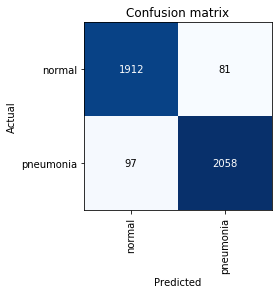

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Prediction on test set

Test images are in `df_test` dataframe removing `covid` images.  We evaluate the performance of the method in terms of the sensitivity and predictive positive value. 

In [50]:
rsna_samples = np.invert(df_test['label'] == 'covid')
df_test_rsna = df_test[rsna_samples]
df_test_rsna.describe()

,name,label
count,1846,1846
unique,1480,2
top,data/COVIDx/test/1c44e0a4-4612-438f-9a83-8d5bf...,pneumonia
freq,4,960


### Predict images

In [51]:
classes = ['normal', 'pneumonia']
test_images = df_test_rsna['name']
labels = df_test_rsna['label']
EVAL_CASES = len(labels)
# PRED_TH = 0.9

# convert labels to numbers to compare
l2n = {'pneumonia': 1, 'normal': 0}
num_labels = [l2n[l] for l in labels]

# compute results
results = {}
predictions = []
for f, l in zip(test_images[:EVAL_CASES], labels[:EVAL_CASES]):
    pred = learn.predict(open_image(f))
    # i = 0 if pred[2][0] >= PRED_TH else np.argmax(pred[2][1:].numpy()) + 1
    i = np.argmax(pred[2].numpy())
    # print('label:', l, pred, i)
    results[f] = classes[i] 
    predictions.append(i)
    


## Compute stats

,class,num samples,sensitivity,precision
0,normal,886,0.987585,0.955240
1,pneumonia,960,0.957292,0.988172


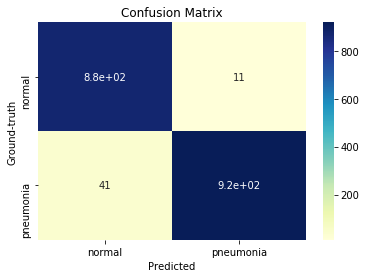

In [54]:
cm = confusion_matrix(num_labels[:EVAL_CASES], predictions, labels = [0, 1])
ax = plt.subplot()
sns.set_color_codes("pastel")
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted');ax.set_ylabel('Ground-truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);


# count elements per class
elements_x_class = [np.sum(num_labels[:EVAL_CASES] == (np.ones(EVAL_CASES) * l))
                    for l in range(2)]

# global accuracy
g_acc = accuracy_score(num_labels[:EVAL_CASES], predictions)
# sensitivity x clas
recall_scores = recall_score(num_labels[:EVAL_CASES], predictions, average=None)
# precision x class
precision_scores = precision_score(num_labels[:EVAL_CASES], predictions, average=None)
d_r = pd.DataFrame({'class': classes, 
                    'num samples': elements_x_class, 
                    'sensitivity': recall_scores, 
                    'precision': precision_scores})
d_r.head()

# Stage 2
----------------

During the second stage, we train a new classifier to differentiate between `covid` and `other` disease types. To do so, we will use the already trained model on `pneumonia vs normal` and fine tune it accordingly.


## Dataset creation

In [196]:
number_samples_x_class = 100

covid_samples = df_train['label'] == 'covid'
pneumonia_samples = df_train['label'] == 'pneumonia'
normal_samples = df_train['label'] == 'normal'

# new dataset creation
covid_df = df_train[covid_samples]
pneumonia_df = df_train[pneumonia_samples].iloc[:number_samples_x_class]
normal_df = df_train[normal_samples].iloc[:number_samples_x_class]
pneumonia_df['label'] = ['other' for l in range(len(normal_df))]
normal_df['label'] = ['other' for l in range(len(normal_df))]

df_train_covid = pd.concat([covid_df, pneumonia_df, normal_df])
df_train_covid.describe()

,name,label
count,297,297
unique,265,2
top,data/COVIDx/train/03a9498c-549d-4e7d-800b-e747...,other
freq,3,200


## Model creation

In [ ]:
# create the current model folder
model_name = 'resnet_covidx_covid'
model_path = os.path.join('models', model_name)
if os.path.exists(model_path) is False:
    os.mkdir(model_path)

In [197]:
data = ImageDataBunch.from_df(path='.', 
                              df=df_train_covid,
                              valid_pct=0.25,
                              test=None,
                              ds_tfms=transforms, 
                              bs=32, 
                              size=256, 
                              num_workers=8).normalize(imagenet_stats)

#show size of our datasets
print("TRAIN:", len(data.train_ds),
      "VALIDATION:", len(data.valid_ds))

precision = Precision()
AUC = AUROC()
learn = cnn_learner(data, models.resnet50, metrics=(accuracy, precision, error_rate, AUC)) 
#data.show_batch(rows=3, figsize=(10,10))

TRAIN: 223 VALIDATION: 74


### 1st round

In [201]:
learn.load(os.path.join('resnet_covidx_pneumonia','resnet_covidx_pneumonia_stage3'))
learn.freeze()
# apply inbalance
import torch.nn as nn
#Learner.crit = nn.CrossEntropyLoss(weight=torch.tensor([1, 1/5]))

learn.fit_one_cycle(100, 
                    max_lr=1e-2,
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy', 
                                                 name=os.path.join(model_name, model_name))])

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,3.854986,1.314988,0.581081,0.767442,0.418919,0.650926,00:05
1,2.272142,0.528398,0.851351,0.957447,0.148649,0.921296,00:05
2,1.683971,0.695118,0.864865,0.958333,0.135135,0.906481,00:05
3,1.385000,0.612131,0.837838,0.956522,0.162162,0.928704,00:05
4,1.152059,0.399266,0.837838,0.956522,0.162162,0.950000,00:06
5,0.943447,0.387189,0.837838,0.920000,0.162162,0.923148,00:05
6,0.798252,0.439452,0.797297,0.897959,0.202703,0.880556,00:05
7,0.692540,0.287702,0.878378,0.924528,0.121622,0.936111,00:05
8,0.596636,0.174224,0.945946,0.946429,0.054054,0.972222,00:05
9,0.518413,0.164143,0.932432,0.945455,0.067568,0.974074,00:05


Better model found at epoch 0 with accuracy value: 0.5810810923576355.
Better model found at epoch 1 with accuracy value: 0.8513513803482056.
Better model found at epoch 2 with accuracy value: 0.8648648858070374.
Better model found at epoch 7 with accuracy value: 0.8783783912658691.
Better model found at epoch 8 with accuracy value: 0.9459459185600281.
Better model found at epoch 16 with accuracy value: 0.9594594836235046.
Better model found at epoch 50 with accuracy value: 0.9729729890823364.


## Compute the accuracy on the validation set

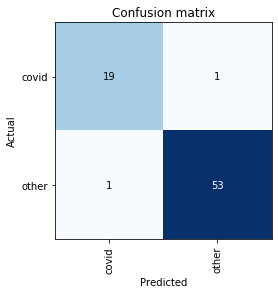

In [202]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Export the model to disk

In [215]:

learn.export()

## Compute the accuracy on the test set

Test images are in `df_test` dataframe removing `covid` images.  We evaluate the performance of the method in terms of the sensitivity and predictive positive value. We only consider the `covid` class and `other`. 

In [ ]:
df_test = pd.read_pickle('covidX_test.pkl')

covid_samples = df_test['label'] == 'covid'
pneumonia_samples = df_test['label'] == 'pneumonia'
normal_samples = df_test['label'] == 'normal'

# new dataset creation
covid_df = df_test[covid_samples]
pneumonia_df = df_test[pneumonia_samples]
normal_df = df_test[normal_samples]
pneumonia_df['label'] = ['other' for l in range(len(pneumonia_df))]
normal_df['label'] = ['other' for l in range(len(normal_df))]

df_test_covid = pd.concat([covid_df, pneumonia_df, normal_df])
df_test_covid.describe()

In [204]:
classes = ['covid', 'other']
test_images = df_test_covid['name']
labels = df_test_covid['label']
EVAL_CASES = len(labels)

# convert labels to numbers to compare
l2n = {'covid': 0, 'other': 1}
num_labels = [l2n[l] for l in labels]

# compute results
results = {}
predictions = []
for f, l in zip(test_images[:EVAL_CASES], labels[:EVAL_CASES]):
    pred = learn.predict(open_image(f))
    # i = 0 if pred[2][0] >= PRED_TH else 1
    i = np.argmax(pred[2].numpy())
    results[f] = classes[i] 
    predictions.append(i)
    


,class,num samples,sensitivity,precision
0,covid,11,0.727273,0.066116
1,other,1846,0.938787,0.998272


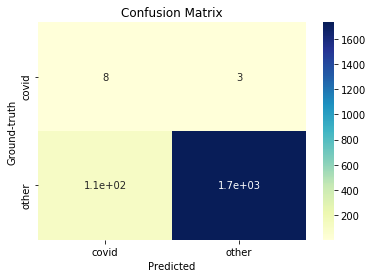

In [205]:
cm = confusion_matrix(num_labels[:EVAL_CASES], predictions, labels = [0, 1])
ax = plt.subplot()
sns.set_color_codes("pastel")
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted');ax.set_ylabel('Ground-truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);


# count elements per class
elements_x_class = [np.sum(num_labels[:EVAL_CASES] == (np.ones(EVAL_CASES) * l))
                    for l in range(2)]

# global accuracy
g_acc = accuracy_score(num_labels[:EVAL_CASES], predictions)
# sensitivity x clas
recall_scores = recall_score(num_labels[:EVAL_CASES], predictions, average=None)
# precision x class
precision_scores = precision_score(num_labels[:EVAL_CASES], predictions, average=None)
d_r = pd.DataFrame({'class': classes, 
                    'num samples': elements_x_class, 
                    'sensitivity': recall_scores, 
                    'precision': precision_scores})
d_r.head()

In [211]:
110 / 1857 * 100

5.923532579429187

## Evaluate the performance on the private dataset

We evaluate the performance on a unseen dataset from a private hospital composed of 5 `covid` and 5 `other` images. 

In [209]:
h_folder = 'data/HJT_COVID_19/images'

classes = ['covid', 'other']
test_images = [os.path.join(h_folder, f) for f in os.listdir(h_folder)]

labels = []
for l in os.listdir(h_folder):
    if l.find('covid') >= 0:
        current_label = 'covid'
    else:
        current_label = 'other'
    labels.append(current_label)
    
PRED_TH = 0.2

# convert labels to numbers to compare
l2n = {'covid': 0, 'other': 1}
num_labels = [l2n[l] for l in labels]

# compute results
results = {}
predictions = []
for f, l in zip(test_images, labels):
    pred = learn.predict(open_image(f))
    im_name = os.path.split(f)[1]
    # i = 0 if pred[2][0] >= PRED_TH else 1
    i = np.argmax(pred[2].numpy())
    print(im_name, 'label:', l, pred, i)
    results[f] = classes[i] 
    predictions.append(i)
    


covid_5.png label: covid (Category covid, tensor(0), tensor([0.9839, 0.0161])) 0
other_2.png label: other (Category other, tensor(1), tensor([1.4452e-06, 1.0000e+00])) 1
other_3.png label: other (Category other, tensor(1), tensor([4.2362e-07, 1.0000e+00])) 1
other_1.png label: other (Category other, tensor(1), tensor([3.2047e-05, 9.9997e-01])) 1
covid_1.png label: covid (Category other, tensor(1), tensor([9.9954e-07, 1.0000e+00])) 1
other_5.png label: other (Category other, tensor(1), tensor([6.2835e-09, 1.0000e+00])) 1
covid_4.png label: covid (Category covid, tensor(0), tensor([1.0000e+00, 1.2485e-06])) 0
covid_3.png label: covid (Category covid, tensor(0), tensor([0.9985, 0.0015])) 0
covid_2.png label: covid (Category other, tensor(1), tensor([4.6560e-07, 1.0000e+00])) 1
other_4.png label: other (Category other, tensor(1), tensor([7.6468e-08, 1.0000e+00])) 1


,class,num samples,sensitivity,precision
0,covid,5,0.6,1.000000
1,other,5,1.0,0.714286


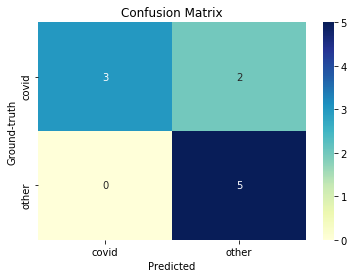

In [210]:
cm = confusion_matrix(num_labels, predictions, labels = [0, 1])
ax = plt.subplot()
sns.set_color_codes("pastel")
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted');ax.set_ylabel('Ground-truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);


# count elements per class
elements_x_class = [np.sum(num_labels == (np.ones(len(num_labels)) * l))
                    for l in range(2)]

# global accuracy
g_acc = accuracy_score(num_labels, predictions)
# sensitivity x clas
recall_scores = recall_score(num_labels, predictions, average=None)
# precision x class
precision_scores = precision_score(num_labels, predictions, average=None)
d_r = pd.DataFrame({'class': classes, 
                    'num samples': elements_x_class, 
                    'sensitivity': recall_scores, 
                    'precision': precision_scores})
d_r.head()